# RNN을 이용한 텍스트 분류

## 설정

In [4]:
!pip install tensorflow_datasets 

  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached promise-2.3-py3-none-any.whl


In [5]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## 입력 파이프 라인 설정

In [7]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This slick and gritty film consistently delivers. It\'s one of Frankenheimer\'s best and most underrated films and it\'s easily the best Elmore Leonard adaptation to date (and if you are scratching your head thinking "but I loved GET SHORTY" you need to be punched in the face). In my opinion, no one captures the "feel" for Leonard\'s characters better then John Glover in 52 PICK-UP. The relocation of the story from Detroit (novel) to Hollywood (film) elevates the story\'s sleaze factor to amazing heights. Be a man, have a few beers and watch this movie. For reference purposes my favorite Leonard books are: Swag, Rum Punch, Cat Chaser, City Primeval, and 52 Pick-Up. My favorite Frankenheimer films include SECONDS and THE MANCHURIAN CANDIDATE. I also have a real special place in my cold, movie heart for DEAD BANG and BLACK Sunday.'
 b"No, this is nothing about that fairy tale with the pumpkin coach, fairy godmother and the glass slippers, but if I were to elaborate, I would ha

## 텍스트 인코더 생성

In [13]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [17]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   1,   3, ...,   0,   0,   0],
       [ 57,  11,   7, ...,   0,   0,   0],
       [ 86, 127, 142, ...,   0,   0,   0]], dtype=int64)

In [18]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This slick and gritty film consistently delivers. It\'s one of Frankenheimer\'s best and most underrated films and it\'s easily the best Elmore Leonard adaptation to date (and if you are scratching your head thinking "but I loved GET SHORTY" you need to be punched in the face). In my opinion, no one captures the "feel" for Leonard\'s characters better then John Glover in 52 PICK-UP. The relocation of the story from Detroit (novel) to Hollywood (film) elevates the story\'s sleaze factor to amazing heights. Be a man, have a few beers and watch this movie. For reference purposes my favorite Leonard books are: Swag, Rum Punch, Cat Chaser, City Primeval, and 52 Pick-Up. My favorite Frankenheimer films include SECONDS and THE MANCHURIAN CANDIDATE. I also have a real special place in my cold, movie heart for DEAD BANG and BLACK Sunday.'
Round-trip:  this [UNK] and [UNK] film [UNK] [UNK] its one of [UNK] best and most [UNK] films and its easily the best [UNK] [UNK] [UNK] to [UNK] 

## 모델 생성

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [20]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [21]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.01424971]


In [22]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01424971]


In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

##  모델 훈련

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 427s 1s/step - loss: 0.6330 - accuracy: 0.5766 - val_loss: 0.5529 - val_accuracy: 0.7182
Epoch 2/10
348/391 [=========================>....] - ETA: 56s - loss: 0.4093 - accuracy: 0.8083

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 15s 38ms/step - loss: 0.3185 - accuracy: 0.8582
Test Loss: 0.3184521794319153
Test Accuracy: 0.8581600189208984


(0.0, 0.6627909764647484)

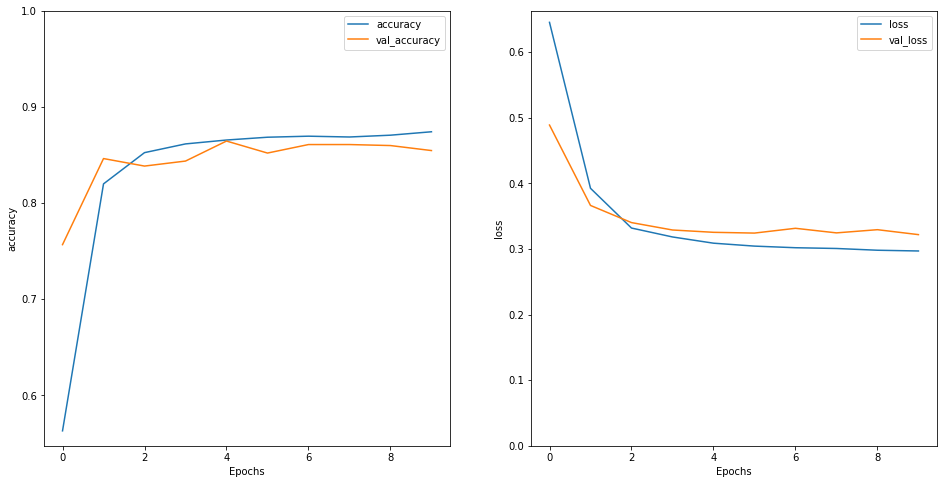

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 71s 149ms/step - loss: 0.6502 - accuracy: 0.5625 - val_loss: 0.4923 - val_accuracy: 0.7573
Epoch 2/10
391/391 [==============================] - 55s 138ms/step - loss: 0.4067 - accuracy: 0.8198 - val_loss: 0.3727 - val_accuracy: 0.8271
Epoch 3/10
391/391 [==============================] - 54s 136ms/step - loss: 0.3417 - accuracy: 0.8543 - val_loss: 0.3343 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3242 - accuracy: 0.8607 - val_loss: 0.3268 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3174 - accuracy: 0.8652 - val_loss: 0.3213 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 52s 132ms/step - loss: 0.3098 - accuracy: 0.8671 - val_loss: 0.3294 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3063 - accuracy: 0.8697 - val_loss: 0.3158 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 26s 65ms/step - loss: 0.3293 - accuracy: 0.8646
Test Loss: 0.329334557056427
Test Accuracy: 0.8646399974822998


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.6796288]]


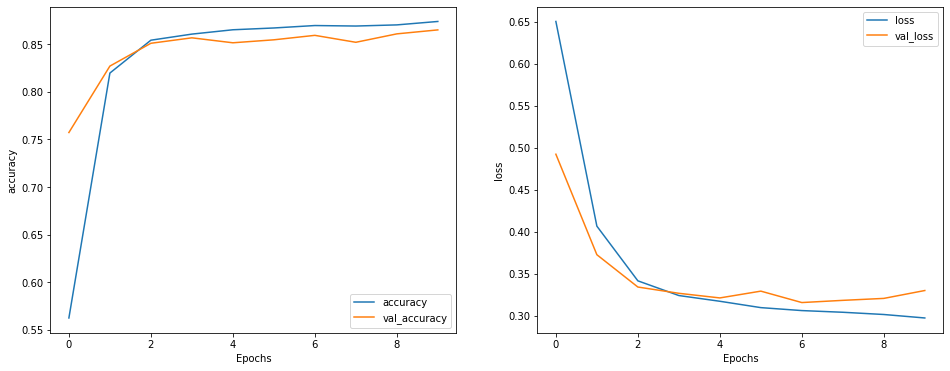

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')